<a href="https://colab.research.google.com/github/KuanChihLee/Supervised-Learning/blob/master/Assignment3_Q6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This assignment section implement a classification case study. The goal is to predict which companies attract venture capital funding by a given dataset about 482 initial public offerings (IPOs) of private companies.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction import DictVectorizer

# Saving TXT file to CSV file
import csv
import sys

txt_file = "./hw3_dataset.txt"
csv_file = "./IPO_dataset.csv"

with open(txt_file, "rt") as fin:
    lines = fin.readlines()
    data = [line.split() for line in lines]        
    
with open(csv_file, 'wt') as fout:
    out_csv = csv.writer(fout)
    out_csv.writerows(data)
    
# Saving CSV file to dataframe
df_IPO = pd.read_csv(csv_file, names=['ID', 'Venture_Fund', 'Face_Value', 'Offer_shares', 'Lev_Buyout'])
df_IPO.head()

,ID,Venture_Fund,Face_Value,Offer_shares,Lev_Buyout
0,1,0,1200000,3000000,0
1,2,0,1454000,1454000,1
2,3,0,1500000,300000,0
3,4,0,1530000,510000,0
4,5,0,2000000,800000,0


## Problem 6

#### Split data into different datasets

In [0]:
Train = df_IPO.sample(frac=0.3333, random_state=20)
df_IPO = df_IPO.drop(Train.index)
Dev = df_IPO.sample(frac=0.5, random_state=20)
Eval = df_IPO.drop(Dev.index)

del Train['ID']
del Dev['ID']
del Eval['ID']
print("Train size:", Train.shape)
print("Dev size:",Dev.shape)
print("Eval size:",Eval.shape)

Train size: (161, 4)
Dev size: (160, 4)
Eval size: (161, 4)


#### Test the performance of raw data

In [0]:
X_train = Train.drop(['Venture_Fund'], axis=1).values
y_train = Train.Venture_Fund.values

X_dev = Dev.drop(['Venture_Fund'], axis=1).values
y_dev = Dev.Venture_Fund.values

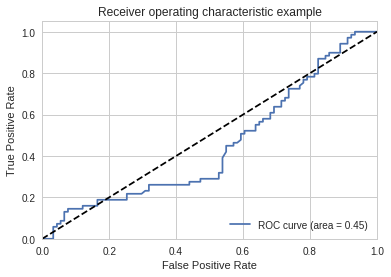

In [0]:
model = LogisticRegression(solver='liblinear', max_iter=1000, fit_intercept=False)
y_score = model.fit(X_train, y_train).decision_function(X_dev)
fpr, tpr, _ = roc_curve(y_dev, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
model_logis = LogisticRegression(solver='liblinear', max_iter=1000, fit_intercept=False).fit(X_train, y_train)
model_LDA = LinearDiscriminantAnalysis(solver='svd').fit(X_train, y_train)

y_pred_train_logis = model_logis.predict(X_train)
y_pred_train_LDA = model_LDA.predict(X_train)
y_pred_dev_logis = model_logis.predict(X_dev)
y_pred_dev_LDA = model_LDA.predict(X_dev)

accur_train_logis = accuracy_score(y_train, y_pred_train_logis)
accur_train_LDA = accuracy_score(y_train, y_pred_train_LDA)
accur_dev_logis = accuracy_score(y_dev, y_pred_dev_logis)
accur_dev_LDA = accuracy_score(y_dev, y_pred_dev_LDA)

print('Logis Train Accuracy %s \n' % (accur_train_logis))
print('LDA Train Accuracy %s \n' % (accur_train_LDA))
print('Logis Dev Accuracy %s \n' % (accur_dev_logis))
print('LDA Dev Accuracy %s \n' % (accur_dev_LDA))

Logis Train Accuracy 0.453416149068323 

LDA Train Accuracy 0.5590062111801242 

Logis Dev Accuracy 0.44375 

LDA Dev Accuracy 0.53125 



### Statistics summary

#### One-variable summary

Text(0.5, 1.0, 'Leveraged Buyout')

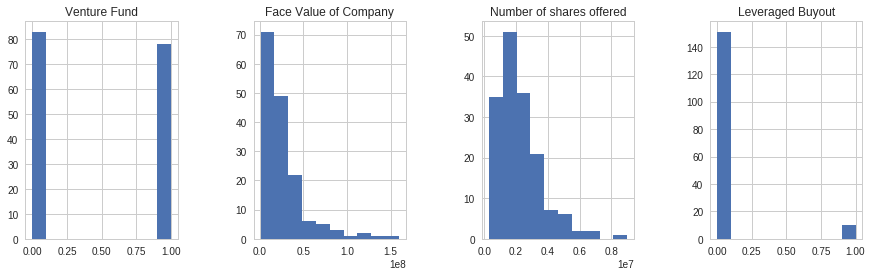

In [0]:
fig, ax = plt.subplots(figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)

plt.subplot(1, 4, 1)
Train.Venture_Fund.hist()
plt.title("Venture Fund")

plt.subplot(1, 4, 2)
Train.Face_Value.hist()
plt.title("Face Value of Company")

plt.subplot(1, 4, 3)
Train.Offer_shares.hist()
plt.title("Number of shares offered")

plt.subplot(1, 4, 4)
Train.Lev_Buyout.hist()
plt.title("Leveraged Buyout")

Face value of company and Number of shares offered are skewed, which means the data in these two predictors are unbalanced spread. We learned using **log transformatio**n to handle the skewness. 

Text(0.5, 1.0, 'Number of shares offered')

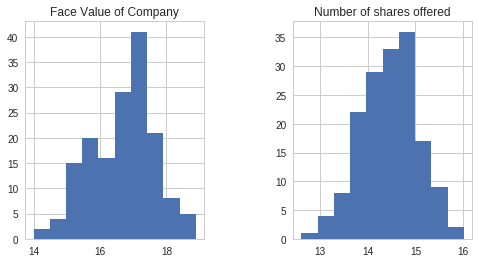

In [0]:
# Applying log(x+1) transformation to all the splits
Train.Face_Value = np.log1p(Train.Face_Value)
Train.Offer_shares = np.log1p(Train.Offer_shares)

Dev.Face_Value = np.log1p(Dev.Face_Value)
Dev.Offer_shares = np.log1p(Dev.Offer_shares)

Eval.Face_Value = np.log1p(Eval.Face_Value)
Eval.Offer_shares = np.log1p(Eval.Offer_shares)

fig, ax = plt.subplots(figsize=(8, 4))
fig.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Train.Face_Value.hist()
plt.title("Face Value of Company")

plt.subplot(1, 2, 2)
Train.Offer_shares.hist()
plt.title("Number of shares offered")

#### Two-variables summary

We're interested in the relationship between the target, verture funding, and other variables. 

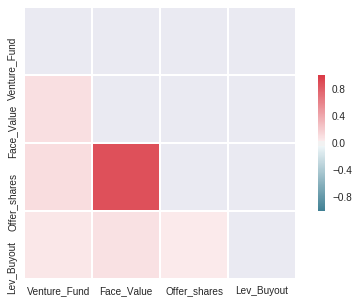

In [0]:
import seaborn as sns; sns.set()
corr = Train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

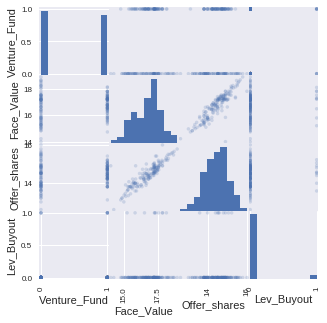

In [0]:
plot = pd.plotting.scatter_matrix(Train[['Venture_Fund', 'Face_Value', 'Offer_shares', 'Lev_Buyout']],
                                  alpha=0.2, figsize=(5,5))

It looks that there is no strong correlation between Venture funding and other variables, but Face value of company and Number of shares offered have very strong relationship to each other. 

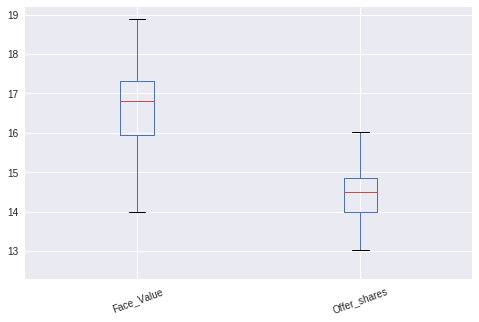

In [0]:
ax = Train.drop(['Venture_Fund', 'Lev_Buyout'], axis=1).boxplot(figsize=(8,5), rot=20)

There are almost no outliers in our dealed data, with log1p transform. Then, we start encoding categorical data into our training data.

### One-Hot Encoder

In [0]:
def transform_categorized_feature(df, *argv):
    df_IPO_features = df.drop([arg for arg in argv], axis=1)

    Lev = ['LB'+str(i) for i in df.Lev_Buyout.values]
    df_IPO_features['Lev_Buyout'] = Lev

    return df_IPO_features

Train_PreOneHot = transform_categorized_feature(Train, 'Lev_Buyout')
vec = DictVectorizer(sparse=False, dtype=int)
Train_OneHot = pd.DataFrame(vec.fit_transform(Train_PreOneHot.to_dict('records')), 
                                       columns=vec.get_feature_names())

Dev_PreOneHot = transform_categorized_feature(Dev, 'Lev_Buyout')
vec = DictVectorizer(sparse=False, dtype=int)
Dev_OneHot = pd.DataFrame(vec.fit_transform(Dev_PreOneHot.to_dict('records')), 
                                       columns=vec.get_feature_names())

Eval_PreOneHot = transform_categorized_feature(Eval, 'Lev_Buyout')
vec = DictVectorizer(sparse=False, dtype=int)
Eval_OneHot = pd.DataFrame(vec.fit_transform(Eval_PreOneHot.to_dict('records')), 
                                       columns=vec.get_feature_names())

print("Train Shape: ", Train_OneHot.shape)
print("Dev Shape: ", Dev_OneHot.shape)
print("Eval Shape: ", Eval_OneHot.shape)
Train_OneHot.head()

Train Shape:  (161, 5)
Dev Shape:  (160, 5)
Eval Shape:  (161, 5)


,Face_Value,Lev_Buyout=LB0,Lev_Buyout=LB1,Offer_shares,Venture_Fund
0,14,1,0,13,0
1,18,1,0,15,0
2,15,1,0,13,0
3,17,1,0,15,0
4,16,1,0,14,1


#### Checking no null values in datasets

In [0]:
for col in Train_OneHot:
    print(col, ': \tTrain: ', Train_OneHot[col].isnull().values.any(), 
          ' \tDev: ', Dev_OneHot[col].isnull().values.any(), 
         ' \tEval: ', Eval_OneHot[col].isnull().values.any())

Face_Value : 	Train:  False  	Dev:  False  	Eval:  False
Lev_Buyout=LB0 : 	Train:  False  	Dev:  False  	Eval:  False
Lev_Buyout=LB1 : 	Train:  False  	Dev:  False  	Eval:  False
Offer_shares : 	Train:  False  	Dev:  False  	Eval:  False
Venture_Fund : 	Train:  False  	Dev:  False  	Eval:  False


#### Testing performance after preprocessing (log transformation and one-hot encoder)

In [0]:
X_train = Train_OneHot.drop('Venture_Fund', axis=1).values
y_train = Train_OneHot.Venture_Fund.values

X_dev = Dev_OneHot.drop('Venture_Fund', axis=1).values
y_dev = Dev_OneHot.Venture_Fund.values

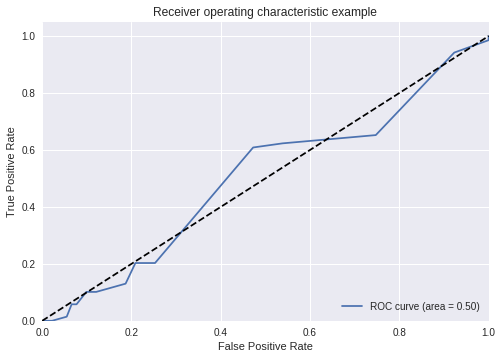

In [0]:
model = LogisticRegression(solver='liblinear', max_iter=1000, fit_intercept=False)
y_score = model.fit(X_train, y_train).decision_function(X_dev)
fpr, tpr, _ = roc_curve(y_dev, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
model_logis = LogisticRegression(solver='liblinear', max_iter=1000, fit_intercept=False).fit(X_train, y_train)
model_LDA = LinearDiscriminantAnalysis(solver='svd').fit(X_train, y_train)

y_pred_train_logis = model_logis.predict(X_train)
y_pred_train_LDA = model_LDA.predict(X_train)
y_pred_dev_logis = model_logis.predict(X_dev)
y_pred_dev_LDA = model_LDA.predict(X_dev)

accur_train_logis = accuracy_score(y_train, y_pred_train_logis)
accur_train_LDA = accuracy_score(y_train, y_pred_train_LDA)
accur_dev_logis = accuracy_score(y_dev, y_pred_dev_logis)
accur_dev_LDA = accuracy_score(y_dev, y_pred_dev_LDA)

print('Logis Train Accuracy %s \n' % (accur_train_logis))
print('LDA Train Accuracy %s \n' % (accur_train_LDA))
print('Logis Dev Accuracy %s \n' % (accur_dev_logis))
print('LDA Dev Accuracy %s \n' % (accur_dev_LDA))

Logis Train Accuracy 0.5217391304347826 

LDA Train Accuracy 0.4782608695652174 

Logis Dev Accuracy 0.51875 

LDA Dev Accuracy 0.50625 



/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


With log transformation for Face value of company and Number of shares offered as well as one-hot encoder for Leverage Buyout, we can obtain a beteer model than the model which uses original raw data as input. But, as we can see above, the AUC area is still low. We need to add more features, such as higher-order terms or interaction between two features.

### Interacting two variables and increasing higher-order terms
Because Face value of company and Number of shares offered terms are high correlated, I try to multiply them together to create a new feature and create second-order terms for each of them.

In [0]:
def Model_complexity_power(dataset, Power):
    data_interaction = dataset.copy()

    for degree in range(Power-1):
        data_interaction['Face'+str(degree+2)] = data_interaction.Face_Value.values ** (degree+2) 
        data_interaction['Share'+str(degree+2)] = data_interaction.Offer_shares.values ** (degree+2)

    data_interaction['FaceXShare'] = data_interaction.Face_Value.values * data_interaction.Offer_shares.values
    data_interaction['Face-Share'] = data_interaction.Face_Value.values - data_interaction.Offer_shares.values
       
    X = data_interaction.drop(['Venture_Fund'], axis=1).values
    y = data_interaction.Venture_Fund.values

    return X, y

def Model_complexity_interaction(dataset, Power, interaction):
    data_interaction = dataset.copy()

    data_interaction['Face2'] = data_interaction.Face_Value.values ** Power
    data_interaction['Share2'] = data_interaction.Offer_shares.values ** Power

    for inter in range(interaction-1):
        data_interaction['Face'+str(inter+2)+'XShare'] = ((data_interaction.Face_Value.values ** (inter+2)) 
                                                          * data_interaction.Offer_shares.values)
        data_interaction['FaceXShare'+str(inter+2)] = (data_interaction.Face_Value.values * 
                                                       (data_interaction.Offer_shares.values ** (inter+2)))
        
    data_interaction['FaceXShare'] = data_interaction.Face_Value.values * data_interaction.Offer_shares.values
    data_interaction['Face-Share'] = data_interaction.Face_Value.values - data_interaction.Offer_shares.values
       
    X = data_interaction.drop(['Venture_Fund'], axis=1).values
    y = data_interaction.Venture_Fund.values

    return X, y

def Model_complexity(dataset, Power, interaction):
    data_interaction = dataset.copy()

    for degree in range(Power-1):
        data_interaction['Face'+str(degree+2)] = data_interaction.Face_Value.values ** (degree+2) 
        data_interaction['Share'+str(degree+2)] = data_interaction.Offer_shares.values ** (degree+2)
        #data_interaction['FaceXLev'+str(degree+2)] = data_interaction.FaceXLev.values ** (degree+2)
        #data_interaction['ShareXLev'+str(degree+2)] = data_interaction.FaceXLev.values ** (degree+2)
        
    for inter in range(interaction-1):
        data_interaction['Face'+str(inter+2)+'XShare'] = ((data_interaction.Face_Value.values ** (inter+2)) 
                                                          * data_interaction.Offer_shares.values)
        data_interaction['FaceXShare'+str(inter+2)] = (data_interaction.Face_Value.values * 
                                                       (data_interaction.Offer_shares.values ** (inter+2)))
        
    data_interaction['FaceXShare'] = data_interaction.Face_Value.values * data_interaction.Offer_shares.values
    data_interaction['Face-Share'] = data_interaction.Face_Value.values - data_interaction.Offer_shares.values
       
    X = data_interaction.drop(['Venture_Fund'], axis=1).values
    y = data_interaction.Venture_Fund.values

    return X, y

#### Using GridSearchCV to find the best parameters

#### Using in Logistic Regreesion- question 6(b)

In [0]:
interaction = 4
power = 4
for degree in range(power):
    for inter in range(interaction):
        X_train, y_train = Model_complexity(Train_OneHot, degree+1, inter+1)
        X_dev, y_dev = Model_complexity(Dev_OneHot, degree+1, inter+1)
        
        logistic = LogisticRegression(solver='liblinear', max_iter=8000, fit_intercept=False)
        penalty = ['l1','l2']
        ## inverse of lambda
        C = np.logspace(0, 2, 7)
        hyperparameters = dict(C=C, penalty=penalty)
        clf = GridSearchCV(logistic, hyperparameters, cv=3)
        best_model = clf.fit(X_train, y_train)
        print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
        print('Best C:', best_model.best_estimator_.get_params()['C'])

        model = LogisticRegression(max_iter = 8000, solver = 'liblinear', fit_intercept=False,
                                   penalty = best_model.best_estimator_.get_params()['penalty'],
                                   C = best_model.best_estimator_.get_params()['C'])
        y_score = model.fit(X_train, y_train).decision_function(X_dev)
        fpr, tpr, _ = roc_curve(y_dev, y_score)
        roc_auc = auc(fpr, tpr)
        print('Degree %s, Interaction %s: ROC curve (area = %0.2f)\n' % (degree+1, inter+1, roc_auc))

Summary:
The combination of features Face value of company and Number of shares offered looks like, x1 + x2 + (x1^2) + (x2^2) +  (x1^x2) + (x1^2) * x2 + (x1^3) * x2 + (x2^2) * x1 + (x2^3) * x1 + (x1 - x2). In this case, I choose the simplest model, which Degree=2, Interaction=3, and AUC=0.68.

It takes so long, so I record the result as below.
1. Degree: 1, Interaction: 1- L1, 100.0, 0.63
2. Degree: 1, Interaction: 2- L1, 10.0, 0.66
3. Degree: 1, Interaction: 3- L1, 1.0, 0.67
4. Degree: 1, Interaction: 4- L1, 1.0, 0.67

1. Degree: 2, Interaction: 1- L1, 100.0, 0.66
2. Degree: 2, Interaction: 2- L1, 10.0, 0.66
3. Degree: 2, Interaction: 3- L2, 1.0, 0.68
4. Degree: 2, Interaction: 4- L1, 1.0, 0.68

1. Degree: 3, Interaction: 1- L1, 3.16, 0.67
2. Degree: 3, Interaction: 2- L1, 100.0, 0.66
3. Degree: 3, Interaction: 3- L2, 10.0, 0.68
4. Degree: 3, Interaction: 4- L1, 3.16, 0.68

1. Degree: 4, Interaction: 1- L1, 1.0, 0.67
2. Degree: 4, Interaction: 2- L2, 1.0, 0.68
3. Degree: 4, Interaction: 3- L1, 1.0, 0.68
4. Degree: 4, Interaction: 4- L1, 3.16, 0.68

Final option: L2, C = 1.0

#### Question 6(c)

In [0]:
interaction = 4
power = 4
for degree in range(power):
    for inter in range(interaction):
        X_train, y_train = Model_complexity(Train_OneHot, degree+1, inter+1)
        X_dev, y_dev = Model_complexity(Dev_OneHot, degree+1, inter+1)
        
        model = LinearDiscriminantAnalysis(solver='lsqr')
        y_score = model.fit(X_train, y_train).decision_function(X_dev)

        fpr, tpr, _ = roc_curve(y_dev, y_score)
        roc_auc = auc(fpr, tpr)
        print('Degree %s, Interaction %s: ROC curve (area = %0.2f)\n' % (degree+1, inter+1, roc_auc))

### Summary
Based on best model/parameters selection (GridsearchCV) from LogisticRegression() and LinearDiscriminantAnalysis(), I choose 4 candidate model- 
1. Degree 1, Interaction 3, L1,  C = 1.0
2. Degree 2, Interaction 3, L2, C = 1.0
3. Degree 3, Interaction 1, L1, C = 3.16
4. Degree 4, Interaction 1, L1, C = 1

#### Problem 6(d)

In [0]:
model_complexity_para = [(1,1,'l1',1.0), (1,3,'l1',1.0), (2,3,'l2',1.0), (3,1,'l1',3.16), (4,1,'l1',1)]
for degree, inter, penalty, C in model_complexity_para:
    X_train, y_train = Model_complexity(Train_OneHot, degree, inter)
    X_dev, y_dev = Model_complexity(Dev_OneHot, degree, inter)
    
    model_logis = LogisticRegression(solver = 'liblinear', fit_intercept=False,
                                     penalty = penalty, C = C).fit(X_train, y_train)
    model_LDA = LinearDiscriminantAnalysis(solver='svd').fit(X_train, y_train)
    
    y_pred_train_logis = model_logis.predict(X_train)
    y_pred_train_LDA = model_LDA.predict(X_train)
    y_pred_dev_logis = model_logis.predict(X_dev)
    y_pred_dev_LDA = model_LDA.predict(X_dev)

    accur_train_logis = accuracy_score(y_train, y_pred_train_logis)
    accur_train_LDA = accuracy_score(y_train, y_pred_train_LDA)
    accur_dev_logis = accuracy_score(y_dev, y_pred_dev_logis)
    accur_dev_LDA = accuracy_score(y_dev, y_pred_dev_LDA)
    
    print('Degree %s, Interaction %s: Logis Train Accuracy %s \n' % (degree, inter, accur_train_logis))
    print('Degree %s, Interaction %s: LDA Train Accuracy %s \n' % (degree, inter, accur_train_LDA))
    print('Degree %s, Interaction %s: Logis Dev Accuracy %s \n' % (degree, inter, accur_dev_logis))
    print('Degree %s, Interaction %s: LDA Dev Accuracy %s \n\n' % (degree, inter, accur_dev_LDA))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Degree 1, Interaction 1: Logis Train Accuracy 0.4968944099378882 

Degree 1, Interaction 1: LDA Train Accuracy 0.6708074534161491 

Degree 1, Interaction 1: Logis Dev Accuracy 0.53125 

Degree 1, Interaction 1: LDA Dev Accuracy 0.625 




/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Degree 1, Interaction 3: Logis Train Accuracy 0.639751552795031 

Degree 1, Interaction 3: LDA Train Accuracy 0.6770186335403726 

Degree 1, Interaction 3: Logis Dev Accuracy 0.60625 

Degree 1, Interaction 3: LDA Dev Accuracy 0.63125 


Degree 2, Interaction 3: Logis Train Accuracy 0.6770186335403726 

Degree 2, Interaction 3: LDA Train Accuracy 0.6770186335403726 

Degree 2, Interaction 3: Logis Dev Accuracy 0.63125 

Degree 2, Interaction 3: LDA Dev Accuracy 0.63125 




/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Degree 3, Interaction 1: Logis Train Accuracy 0.6335403726708074 

Degree 3, Interaction 1: LDA Train Accuracy 0.6770186335403726 

Degree 3, Interaction 1: Logis Dev Accuracy 0.5875 

Degree 3, Interaction 1: LDA Dev Accuracy 0.63125 


Degree 4, Interaction 1: Logis Train Accuracy 0.639751552795031 

Degree 4, Interaction 1: LDA Train Accuracy 0.6770186335403726 

Degree 4, Interaction 1: Logis Dev Accuracy 0.60625 

Degree 4, Interaction 1: LDA Dev Accuracy 0.63125 




/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


#### Conclusion- question 6(e)

(1) The results shown above are improved a lot compared with the result using raw data as input.

(2) We can observe that Linear Discriminant Analysis seems to be the upper bound of Linear Regression. Furthermore, if I choose the model out of my candidate models, I will obtain a result that always smaller than LDA accuracy.

(3) Based on the results shown above, I choose the second one (degree=2, Interaction=3) as my final model.

(4) But, the performance of my designed models are still poor, about 0.68 in training dataset and 0.63 in developing dataset.

(5) Totally, I think that my models are still underfitting because both training and developing errors are pretty high. Furthermore, the training accuracy should be always higher than developing accuracy because we fit our model by training dataset, but sometimes if it's underfitting or training dataset is too complicated to interpret, developing accuracy will be higher than training accuracy.